# DL CW2
Hathik Ihthizam - 012
Nuhan Gunasekara - 013

# ToMate: Your Smart Guard Against Tomato Diseases.

## Problem
Tomato plants are susceptible to various diseases (e.g., bacterial spot, early blight), which significantly impact agricultural productivity. Manual diagnosis is time-consuming and error-prone. ToMate addresses the need for an automated, scalable solution to detect diseases accurately and efficiently, reducing crop losses and supporting sustainable farming.

## Objective
ToMate aims to develop a deep learning model to accurately detect diseases in tomato leaves using image data. The goal is to empower farmers and gardeners with an accessible tool for early diagnosis, enabling timely intervention to improve crop health and yield. The model will be integrated into a web application for user-friendly disease detection, with future plans to enhance real-time prediction using bounding box techniques.

## Project Workflow

The project follows a systematic process, starting with data collection, which involves gathering a diverse set of images representing different tomato diseases and healthy plants. Data preprocessing ensures the dataset is clean and augmented, preparing it for model training. A convolutional neural network (CNN) is trained on this dataset to learn distinguishing features for each class. The model's performance is evaluated using metrics like AUC, precision, recall, and F1-score, and ROC curves visualize the trade-offs between sensitivity and specificity. Finally, the trained model is deployed for practical use, potentially in an app that assists farmers with plant disease diagnosis.

In [ ]:
# System and Data Handling Imports
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import cv2

# Skimage Imports for Image Processing
from skimage import exposure

# TensorFlow and Keras Imports for Model Building and Training
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, BackupAndRestore
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2

# Scikit-learn Imports for Metrics and Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kinganubis","key":"1503b200d3609eec67430e11e8ebdaa8"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
100% 656M/658M [00:29<00:00, 24.1MB/s]
100% 658M/658M [00:29<00:00, 23.1MB/s]


In [ ]:
!ls

drive  kaggle.json  plantdisease.zip  sample_data


In [ ]:
!unzip -qq *.zip

In [ ]:
!ls

drive  kaggle.json  plantdisease.zip  plantvillage  PlantVillage  sample_data


In [ ]:
!ls /content/PlantVillage

Pepper__bell___Bacterial_spot  Tomato_Bacterial_spot  Tomato_Septoria_leaf_spot
Pepper__bell___healthy	       Tomato_Early_blight    Tomato_Spider_mites_Two_spotted_spider_mite
Potato___Early_blight	       Tomato_healthy	      Tomato__Target_Spot
Potato___healthy	       Tomato_Late_blight     Tomato__Tomato_mosaic_virus
Potato___Late_blight	       Tomato_Leaf_Mold       Tomato__Tomato_YellowLeaf__Curl_Virus


In [ ]:
# Step 2: Data Preparation

# Define paths for the dataset
source_dir = '/content/PlantVillage'
destination_dir = '/content/tomato_data'

In [ ]:
tomato_folders = [
    "Tomato_Bacterial_spot", "Tomato_Septoria_leaf_spot", "Tomato_Early_blight",
    "Tomato_Spider_mites_Two_spotted_spider_mite", "Tomato_healthy", "Tomato_Late_blight",
    "Tomato_Leaf_Mold", "Tomato__Target_Spot", "Tomato__Tomato_mosaic_virus", "Tomato__Tomato_YellowLeaf__Curl_Virus"
]


The dataset is organized into folders for each disease class. Only tomato-specific folders are copied to a new directory (tomato_data) to focus on tomato diseases. This ensures the model is trained on relevant data.

In [ ]:
# Create directories and copy relevant folders
os.makedirs(destination_dir, exist_ok=True)
for folder in tomato_folders:
    src_folder = os.path.join(source_dir, folder)
    dst_folder = os.path.join(destination_dir, folder)
    shutil.copytree(src_folder, dst_folder)


The dataset is split into training (80%), validation (10%), and test (10%) sets. This ensures the model is evaluated on unseen data, preventing overfitting. The validation set is used to tune hyperparameters, while the test set provides an unbiased evaluation of the final model.

In [ ]:
# Cell 4: Split Dataset Function
def split_dataset(source_dir, destination_dir, train_size=0.8, val_size=0.1, test_size=0.1):
    splits = ['train', 'val', 'test']
    split_dirs = {split: os.path.join(destination_dir, split) for split in splits}

    for dir_path in split_dirs.values():
        os.makedirs(dir_path, exist_ok=True)

    for disease_class in os.listdir(source_dir):
        class_path = os.path.join(source_dir, disease_class)
        if not os.path.isdir(class_path):
            continue

        for dir_path in split_dirs.values():
            os.makedirs(os.path.join(dir_path, disease_class), exist_ok=True)

        images = os.listdir(class_path)
        train_imgs, temp_imgs = train_test_split(images, train_size=train_size, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

        for img, split in zip([train_imgs, val_imgs, test_imgs], splits):
            for image in img:
                src = os.path.join(class_path, image)
                dst = os.path.join(split_dirs[split], disease_class, image)
                shutil.copy(src, dst)


In [ ]:
# Cell 5: Execute Split Dataset
source_dir = '/content/tomato_data'
destination_dir = '/content/tomato_split_data'
split_dataset(source_dir, destination_dir)

In [ ]:
# Cell 6: Print Class Distribution
split_dataset_path = '/content/tomato_split_data/train'
class_names = [folder for folder in os.listdir(split_dataset_path)
               if os.path.isdir(os.path.join(split_dataset_path, folder))]

for class_name in class_names:
    class_path = os.path.join(split_dataset_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"{class_name}: {num_images} images")

Tomato_Leaf_Mold: 761 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 2567 images
Tomato_Late_blight: 1527 images
Tomato__Tomato_mosaic_virus: 298 images
Tomato_Septoria_leaf_spot: 1416 images
Tomato_Bacterial_spot: 1701 images
Tomato__Target_Spot: 1123 images
Tomato_healthy: 1272 images
Tomato_Spider_mites_Two_spotted_spider_mite: 1340 images
Tomato_Early_blight: 800 images


In [ ]:
# Cell 7: Data Generators Setup
target_size = (224, 224)
batch_size = 32
num_classes = 10
channels = 3
epochs = 100

def contrast_stretching(image):
    p2, p98 = np.percentile(image, (2, 98))
    image = exposure.rescale_intensity(image, in_range=(p2, p98))
    return image


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    channel_shift_range=30.0,
    shear_range=20.0
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3])

test_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3])


train_generator = train_datagen.flow_from_directory(
    '/content/tomato_split_data/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    '/content/tomato_split_data/val',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    '/content/tomato_split_data/test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 12804 images belonging to 10 classes.
Found 1601 images belonging to 10 classes.
Found 1606 images belonging to 10 classes.


* Rescaling: Normalizes pixel values to [0, 1], which is essential for stable training.

* Augmentation: Random rotations, shifts, flips, and brightness adjustments increase dataset diversity, reducing overfitting.

* Fill Mode: Ensures no blank spaces are created during transformations, maintaining image integrity.

In [ ]:
# Cell 8: Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.7527336860670194, 1: 1.6005, 2: 0.8385068762278979, 3: 1.6825229960578187, 4: 0.9042372881355932, 5: 0.9555223880597015, 6: 1.140160284951024, 7: 0.4989867498051442, 8: 4.296644295302014, 9: 1.0066037735849056}


Computes class weights to address class imbalance. For example, if one class has significantly fewer samples, it will be given a higher weight during training. This ensures the model does not become biased toward the majority class.

In [ ]:
# Cell 4: Custom Callback for Gradual Unfreezing
class GradualUnfreezing(tf.keras.callbacks.Callback):
    def __init__(self, base_model, num_epochs_per_unfreeze=5):
        super().__init__()
        self.base_model = base_model
        self.num_epochs_per_unfreeze = num_epochs_per_unfreeze
        self.unfrozen_layers = 0

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.num_epochs_per_unfreeze == 0:
            if self.unfrozen_layers < len(self.base_model.layers):
                for layer in self.base_model.layers[-(self.unfrozen_layers + 10):]:
                    layer.trainable = True
                self.unfrozen_layers += 10
                print(f"\nUnfreezing layers: {self.unfrozen_layers}")

The GradualUnfreezing callback fine-tunes a pretrained model by progressively unfreezing its layers during training. It takes the base_model and num_epochs_per_unfreeze (default: 5) as inputs. At the end of each epoch, if the epoch number is a multiple of num_epochs_per_unfreeze, it unfreezes the next 10 layers from the end of the model. This approach is crucial for transfer learning, as it allows the model to first learn high-level features with frozen pretrained layers and then adapt deeper layers to the specific task. Gradual unfreezing prevents overfitting, ensures stable training, and avoids catastrophic forgetting. For example, with num_epochs_per_unfreeze=5, the callback unfreezes 10 layers every 5 epochs, enabling controlled and efficient fine-tuning.



In [ ]:
# Cell 5: Enhanced Model Architecture
# Initialize ResNet50V2 base
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(target_size[0], target_size[1], channels)
)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Build model with residual connections
inputs = tf.keras.Input(shape=(target_size[0], target_size[1], channels))
x = base_model(inputs)

# Global pooling and initial dropout
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

# First residual block
x1 = layers.Dense(512, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Dropout(0.15)(x1)
x_res = layers.Dense(512, activation='linear')(x)
x = layers.Add()([x_res, x1])
x = layers.Activation('relu')(x)

# Second residual block
x2 = layers.Dense(256, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x2 = layers.Dropout(0.1)(x2)
x_res2 = layers.Dense(256, activation='linear')(x)
x = layers.Add()([x_res2, x2])
x = layers.Activation('relu')(x)


outputs = layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


### Base Model Initialization
The model begins with ResNet50V2, preloaded with ImageNet weights (weights='imagenet'). The top classification layer is removed (include_top=False) to allow customization. The input shape is set to (224, 224, 3) to match the image dimensions.

### Freezing Layers
Initially, all layers in the base model are frozen to retain pretrained features. This prevents unnecessary updates during the early training phase.

### Custom Layers
A GlobalAveragePooling2D layer reduces spatial dimensions, followed by a Dropout layer (20%) to prevent overfitting.

Two residual blocks enhance learning:

* Each block contains a Dense layer with ReLU activation, BatchNormalization, and Dropout.
* A skip connection (Add) improves gradient flow, stabilizing training and boosting performance.

### Output Layer
A Dense layer with softmax activation generates probabilities for 10 tomato disease classes.

### Model Compilation
The model is built using tf.keras.Model, linking input and output layers for a structured pipeline.

### How Model Works for Tomato Disease Detection
* Input: A 224x224 RGB image of a tomato leaf.
* Feature Extraction: The ResNet50V2 base extracts high-level features.
* Custom Layers: Global pooling and residual blocks refine these features.
* Output: The model predicts probabilities for 10 disease classes.

This architecture leverages transfer learning for efficient training, while residual connections enhance stability and accuracy.

In [ ]:
# Cell 6: Learning Rate Schedule
initial_learning_rate = 1e-4
warmup_epochs = 5

def warmup_cosine_decay_schedule(epoch):
    if epoch < warmup_epochs:
        return initial_learning_rate * ((epoch + 1) / warmup_epochs)
    else:
        return initial_learning_rate * (0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs))))

This code defines a warmup cosine decay learning rate schedule to optimize model training.

The initial learning rate is set to 1e-4, a small value to ensure stable training from the start.

During the warmup phase (first 5 epochs by default), the learning rate gradually increases from 0 to 1e-4. This helps stabilize the model and prevents large gradient updates early in training.

After warmup, the cosine decay phase begins, where the learning rate smoothly decreases from 1e-4 to 0 over the remaining epochs. This ensures fine-grained adjustments toward the end of training.

By combining warmup (for stability) and cosine decay (for smooth convergence), this schedule effectively improves training for deep learning models like the tomato disease detection model.

In [ ]:
# Cell 7: Callbacks Setup
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        min_delta=1e-4,
        verbose=1
    ),
    ModelCheckpoint(
        'best_CLDmodel_0109.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    LearningRateScheduler(warmup_cosine_decay_schedule),
    GradualUnfreezing(base_model),
    BackupAndRestore(backup_dir='./backup'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]


## Callbacks Setup
This code configures callbacks to enhance and monitor the training of the tomato disease detection model.

* The EarlyStopping callback monitors val_loss and stops training if no improvement is seen for 10 epochs (patience=10). It restores the best model weights, preventing overfitting and saving training time.

* ModelCheckpoint saves the model (best_CLDmodel_0109.keras) whenever val_accuracy improves, ensuring the best-performing model is retained for deployment.

* LearningRateScheduler applies warmup_cosine_decay_schedule, dynamically adjusting the learning rate. This combines warmup for stability and cosine decay for smooth optimization.

* GradualUnfreezing progressively unfreezes ResNet50V2 layers, allowing the model to fine-tune while balancing pretrained knowledge and task-specific learning.

* BackupAndRestore saves training progress to ./backup, ensuring training can resume if interrupted, avoiding progress loss in long sessions.

Finally, TensorBoard logs training metrics enabling real-time visualization and debugging.

Together, these callbacks ensure efficient, stable, and well-monitored training, leading to a high-performing model.

In [ ]:
# Cell 8: Model Compilation
optimizer = AdamW(learning_rate=initial_learning_rate, weight_decay=1e-4)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()]
)

## Model Compilation
This code compiles the tomato disease detection model, configuring it for efficient training.

The optimizer used is AdamW, a variant of Adam with weight decay (1e-4). This combines adaptive learning rates with regularization, improving generalization.

For loss function, CategoricalCrossentropy with label smoothing (0.1) is applied. Label smoothing prevents overconfidence in predictions, enhancing model robustness.

The model is evaluated using multiple metrics:

* Accuracy: Measures the proportion of correctly classified samples.
* AUC (Area Under Curve): Assesses the model’s ability to distinguish between disease classes.
* Precision & Recall: Evaluate performance in terms of false positives and false negatives, crucial for imbalanced datasets.

With these settings, the model is optimized for stable learning, ensuring accurate tomato leaf disease classification while avoiding overfitting.

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50v2 (Functional)   │ (None, 7, 7, 2048)     │     23,564,800 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50v2[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      1,049,088 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512)            │          2,048 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │      1,049,088 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 512)            │              0 │ dense_1[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512)            │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        131,328 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256)            │              0 │ dense_3[0][0],         │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256)            │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 10)             │          2,570 │ activation_1[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,930,250 (98.92 MB)

 Trainable params: 2,364,426 (9.02 MB)

 Non-trainable params: 23,565,824 (89.90 MB)

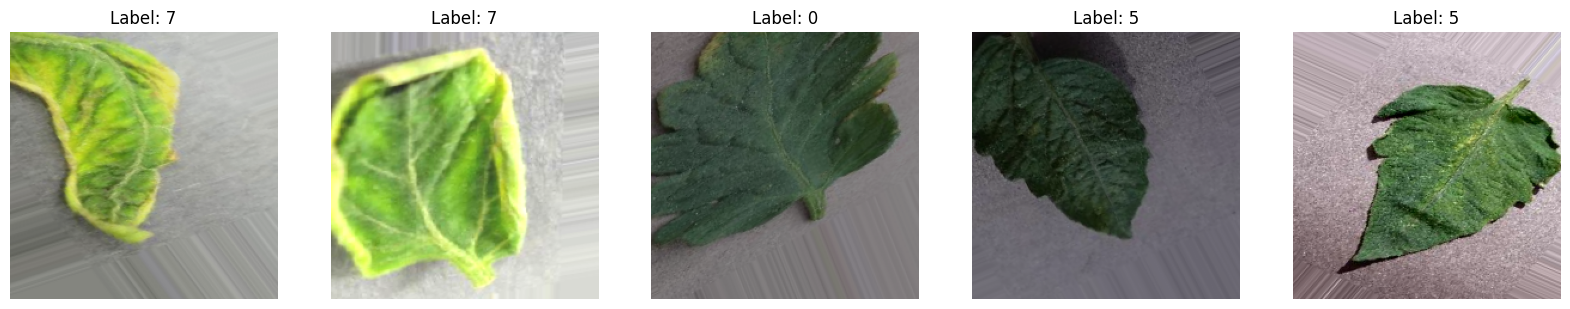

In [ ]:
images, labels = next(train_generator)
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].set_title(f"Label: {np.argmax(labels[i])}")
    axes[i].axis('off')
plt.show()


Found 12804 images belonging to 10 classes.


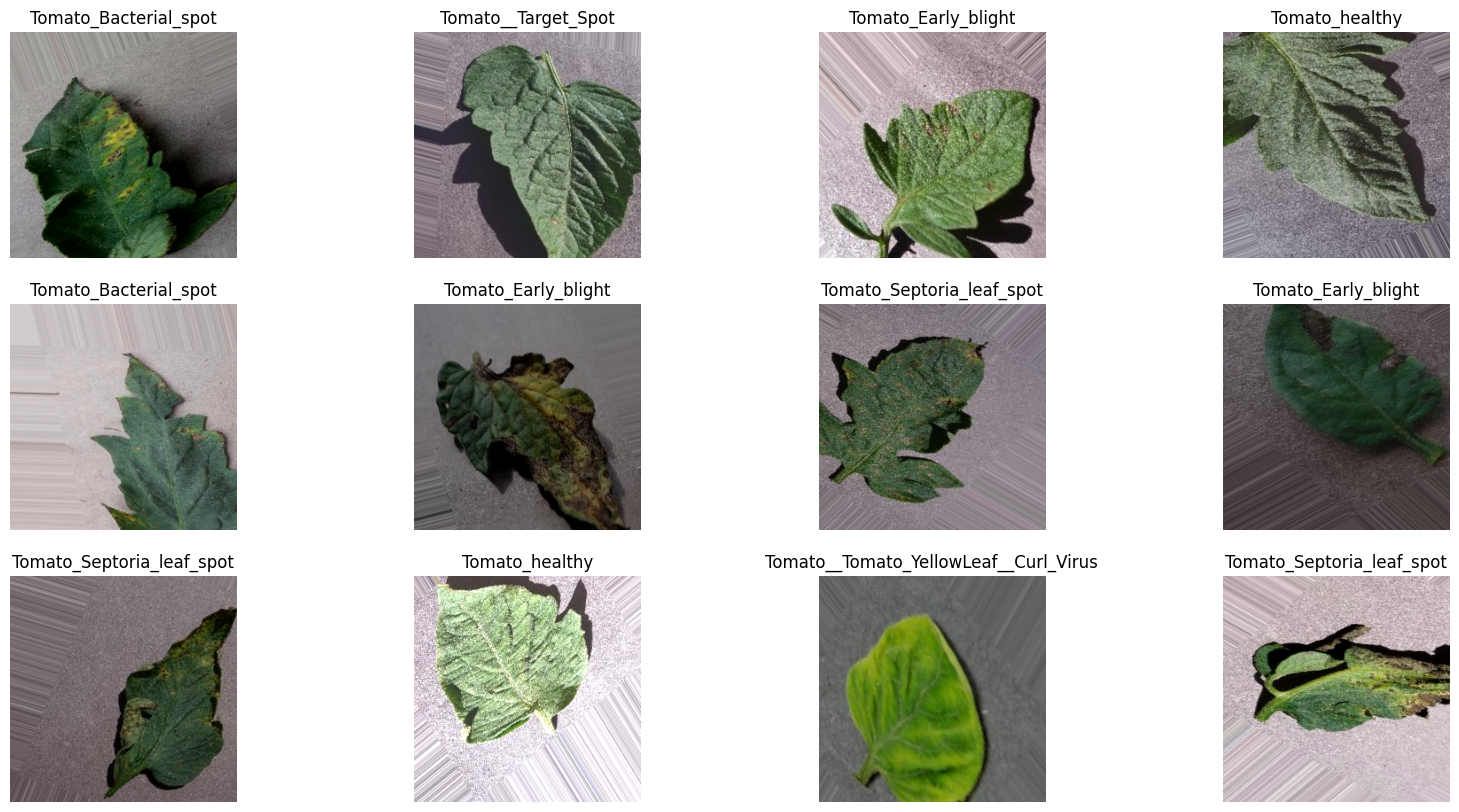

In [ ]:
# Fetch a batch of images and labels from the training set
images, labels = next(iter(train_datagen.flow_from_directory('/content/tomato_split_data/train', batch_size=32)))

# Display some images with applied augmentations and contrast stretching
plt.figure(figsize=(20, 10))

# Access class names from train_generator (the flow_from_directory object)
class_names = list(train_generator.class_indices.keys())

for i in range(12):
    if i >= len(images):
        break
    ax = plt.subplot(3, 4, i + 1)
    img = images[i] * 255.0
    plt.imshow(img.astype("uint8"))


    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')

plt.show()

In [ ]:
# Cell 10: Model Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.1910 - auc: 0.5983 - loss: 2.9152 - precision: 0.2594 - recall: 0.0654
Epoch 1: val_accuracy improved from -inf to 0.52904, saving model to best_CLDmodel_0109.keras
401/401 ━━━━━━━━━━━━━━━━━━━━ 253s 567ms/step - accuracy: 0.1912 - auc: 0.5985 - loss: 2.9141 - precision: 0.2598 - recall: 0.0656 - val_accuracy: 0.5290 - val_auc: 0.8827 - val_loss: 1.7096 - val_precision: 0.8716 - val_recall: 0.2630 - learning_rate: 2.0000e-05
Epoch 2/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.4761 - auc: 0.8570 - loss: 1.8956 - precision: 0.6883 - recall: 0.2784
Epoch 2: val_accuracy improved from 0.52904 to 0.66958, saving model to best_CLDmodel_0109.keras
401/401 ━━━━━━━━━━━━━━━━━━━━ 209s 510ms/step - accuracy: 0.4761 - auc: 0.8570 - loss: 1.8954 - precision: 0.6884 - recall: 0.2785 - val_accuracy: 0.6696 - val_auc: 0.9455 - val_loss: 1.4154 - val_precision: 0.8764 - val_recall: 0.4472 - learning_rate: 4.0000e-05
Epoch 3/100
401

In [ ]:
# Cell 11: Save Model
model.save('final_CLDtomato_model_0109.keras')

In [ ]:
# Cell 14: Model Evaluation
test_results = model.evaluate(test_generator)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
print(f"Test Precision: {test_results[3]:.4f}")
print(f"Test Recall: {test_results[4]:.4f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - accuracy: 0.9343 - auc: 0.9962 - loss: 0.7713 - precision: 0.9628 - recall: 0.8809
Test Loss: 0.7588
Test Accuracy: 0.9309
Test AUC: 0.9969
Test Precision: 0.9581
Test Recall: 0.8823


## Model Evaluation Results
The model achieves strong performance on the test set, proving its effectiveness in detecting tomato leaf diseases.

* Test Loss (0.7588)
A lower loss indicates better prediction accuracy. With a value of 0.7588, the model is making accurate classifications.

* Test Accuracy (0.9309)
The model correctly classifies 93.09% of test images, showing high reliability in disease detection.

* Test AUC (0.9969)
AUC measures the model’s ability to distinguish between disease classes. A value of 0.9969 (close to 1) suggests excellent class separation and strong predictive confidence.

* Test Precision (0.9581)
Precision assesses false positives. With a value of 0.9581, the model produces very few incorrect positive predictions, making it highly trustworthy.

* Test Recall (0.8823)
Recall measures false negatives. A value of 0.8823 means the model captures most diseased cases, ensuring minimal missed detections.

In [ ]:
# Cell 11: Model Evaluation
# Evaluate the model on the validation set
# model.evaluate returns a list of values: [loss, accuracy, auc, precision, recall]
eval_results = model.evaluate(val_generator, verbose=1)
val_loss = eval_results[0]  # Loss is the first element
val_accuracy = eval_results[1]  # Accuracy is the second element
# ... (access other metrics similarly)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


# Evaluate the model on the test set (if available)
eval_results = model.evaluate(test_generator, verbose=1)
test_loss = eval_results[0]  # Loss is the first element
test_accuracy = eval_results[1]  # Accuracy is the second element
# ... (access other metrics similarly)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.9186 - auc: 0.9950 - loss: 0.7896 - precision: 0.9632 - recall: 0.8608
Validation Loss: 0.781829833984375
Validation Accuracy: 0.9163023233413696
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9261 - auc: 0.9962 - loss: 0.7740 - precision: 0.9633 - recall: 0.8762
Test Loss: 0.7594513297080994
Test Accuracy: 0.9265255331993103


## Validation Metrics

* Validation Loss: 0.7818
The validation loss is slightly lower than the training loss.
This indicates good generalization without signs of overfitting.

*Validation Accuracy: 0.9163
The model achieves 91.63% accuracy on the validation set.
This confirms its ability to generalize well to unseen data.

The model maintains high validation accuracy and low loss, demonstrating strong performance in detecting tomato leaf diseases across new samples.

In [ ]:
# Generate predictions for further analysis (optional)
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted classes
y_true = test_generator.classes  # True classes

# Generate a classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.93      0.98      0.95       213
                        Tomato_Early_blight       0.90      0.87      0.88       100
                         Tomato_Late_blight       0.95      0.84      0.89       191
                           Tomato_Leaf_Mold       0.95      0.92      0.93        96
                  Tomato_Septoria_leaf_spot       0.93      0.93      0.93       178
Tomato_Spider_mites_Two_spotted_spider_mite       0.83      0.95      0.89       168
                        Tomato__Target_Spot       0.86      0.82      0.84       141
      Tomato__Tomato_YellowLeaf__Curl_Virus       1.00      0.98      0.99       321
                Tomato__Tomato_mosaic_virus       0.80      0.97      0.88        38
                             Tomato_healthy       0.97      0.97      0.97       160

                     

## Classification Report
The classification report shows that the model performs exceptionally well across most tomato disease classes, achieving 93% accuracy with high precision, recall, and F1-scores. It correctly identifies diseases like Tomato_Bacterial_spot (F1: 0.95) and Tomato__Tomato_YellowLeaf__Curl_Virus (F1: 0.99) with near-perfect accuracy. Some classes, like Tomato__Target_Spot (F1: 0.84) and Tomato__Tomato_mosaic_virus (F1: 0.88), have slightly lower performance, suggesting room for improvement. The model maintains a good balance between precision and recall, making it reliable for real-world tomato disease detection.









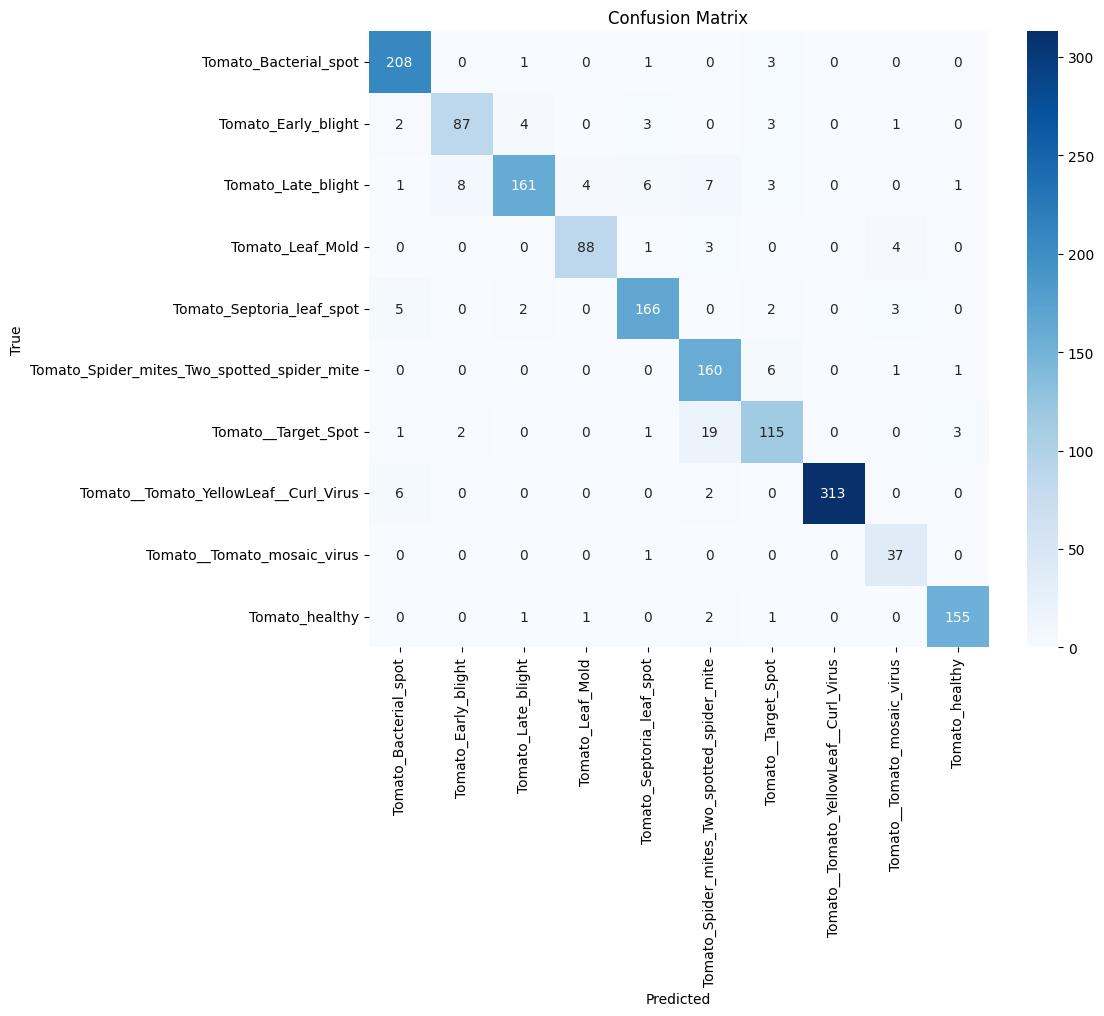

In [ ]:
# Plot confusion matrix (optional, for better insights)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

The confusion matrix illustrates the model's performance in classifying different tomato leaf diseases. The diagonal values represent the correctly predicted instances for each class, showing strong performance, especially for Tomato__Tomato_YellowLeaf__Curl_Virus (313 correct predictions) and Tomato_Bacterial_spot (208 correct predictions). Most misclassifications involve similar disease types, such as Tomato_Late_blight, which has some overlap with Tomato_Early_blight and Tomato_Septoria_leaf_spot. Some minor confusion occurs in Tomato_mosaic_virus (37 correct predictions) and Tomato_Target_Spot (115 correct predictions), indicating potential challenges in differentiating these classes. Overall, the model exhibits high accuracy with minimal misclassification, confirming its strong performance in tomato disease detection.

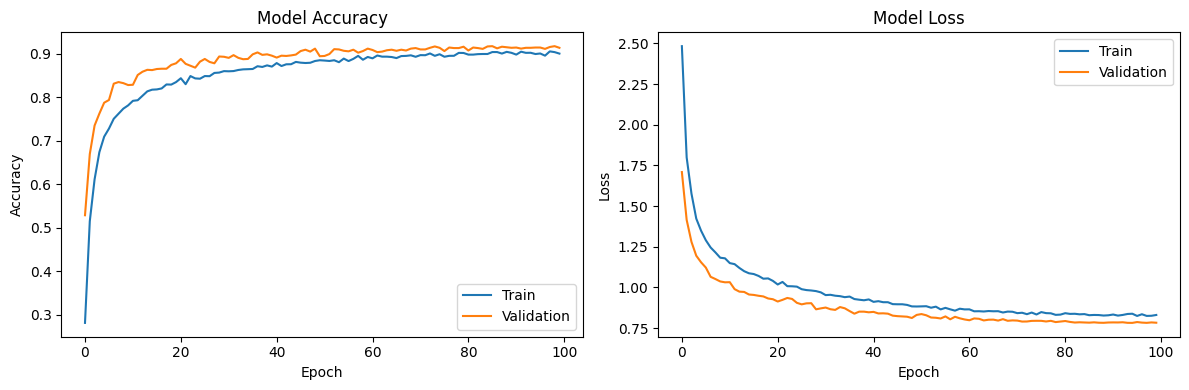

In [ ]:
# Cell 12: Plot Training History
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

The training plots show the model's accuracy and loss over 100 epochs. The **accuracy curve** indicates steady improvement, with both training and validation accuracy reaching over **90%**, suggesting strong generalization. The **loss curve** shows a sharp decline initially, then stabilizes, with validation loss slightly lower than training loss. There are **no major gaps** between training and validation curves, meaning the model is **not overfitting**. If overfitting were present, the validation loss would increase while training loss continued decreasing. Similarly, **no underfitting** is observed, as both accuracies are high, and loss is consistently reducing. The model appears well-trained, with **good generalization** and minimal overfitting concerns.

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step


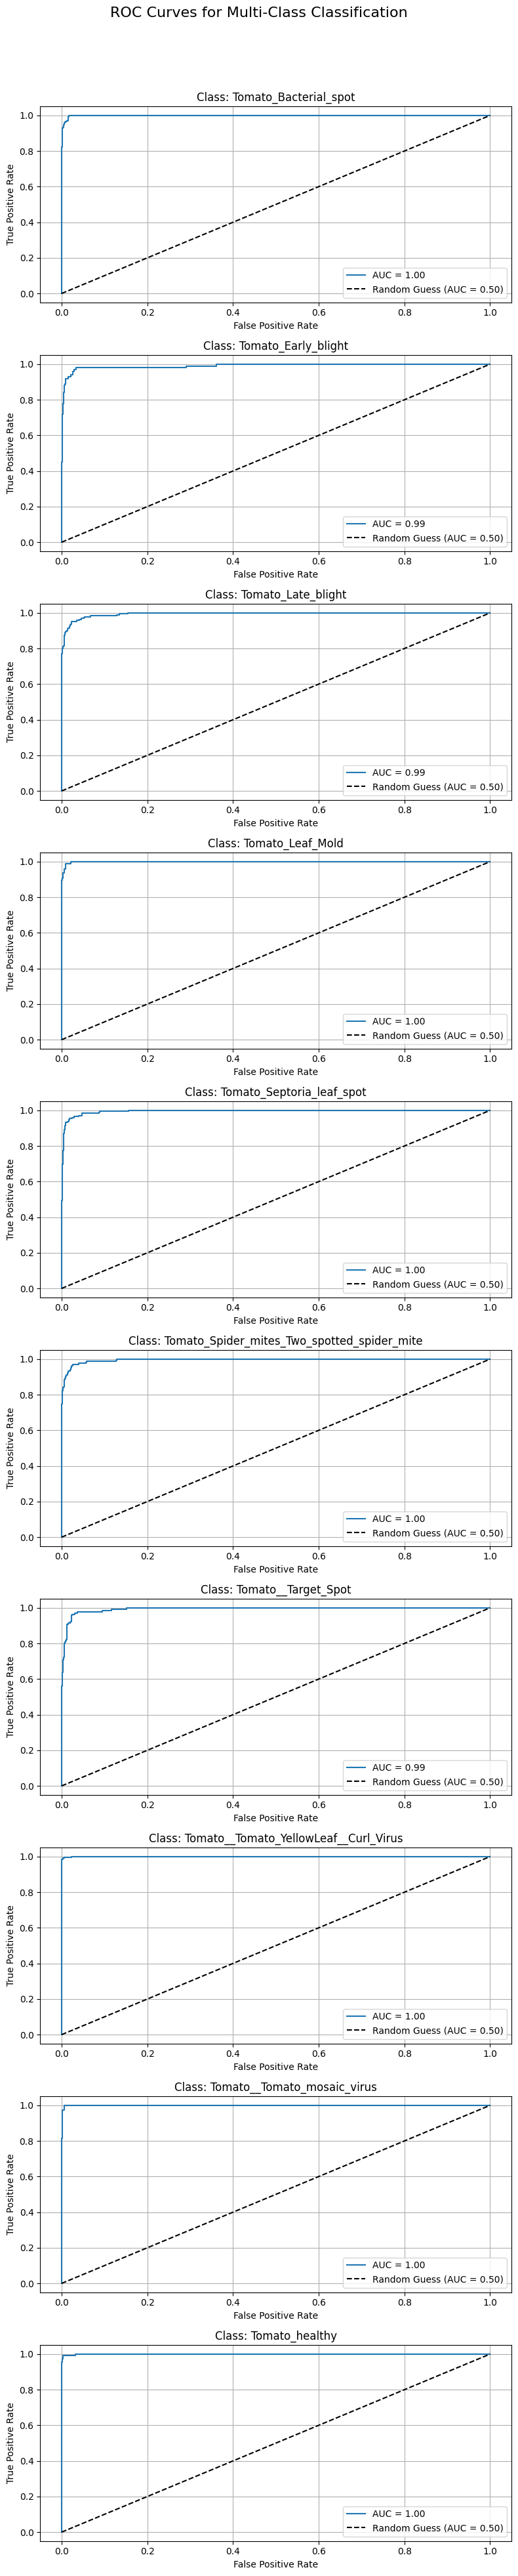

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the true labels for multi-class ROC
y_true_binarized = label_binarize(y_true, classes=list(range(len(test_generator.class_indices))))
n_classes = y_true_binarized.shape[1]

# Predict probabilities for the test set
y_pred_probs = model.predict(test_generator, verbose=1)

# Create subplots for ROC curves
fig, axes = plt.subplots(n_classes, 1, figsize=(8, n_classes * 4))
fig.suptitle("ROC Curves for Multi-Class Classification", fontsize=16)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve in a separate subplot
    axes[i].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    axes[i].plot([0, 1], [0, 1], "k--", label="Random Guess (AUC = 0.50)")
    axes[i].set_title(f"Class: {list(test_generator.class_indices.keys())[i]}")
    axes[i].set_xlabel("False Positive Rate")
    axes[i].set_ylabel("True Positive Rate")
    axes[i].legend(loc="lower right")
    axes[i].grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
plt.show()


The graph presents Receiver Operating Characteristic (ROC) curves for multi-class classification of various tomato diseases and healthy plants. Each curve represents the performance of a classifier for a specific class, with the True Positive Rate (sensitivity) plotted against the False Positive Rate (1-specificity). The Area Under the Curve (AUC) values indicate the classifier's effectiveness, with an AUC of 1.00 representing perfect classification and 0.99 indicating very high accuracy. The dashed line represents a random guess with an AUC of 0.50. Most classes, such as Tomato_Bacterial_spot and Tomato_healthy, achieve perfect classification (AUC = 1.00), while others like Tomato_Early_blight and Tomato_Target_Spot show near-perfect performance (AUC = 0.99). This suggests the classifier is highly effective in distinguishing between different tomato diseases and healthy plants.

## Final Output
The deployed web application allows users to upload tomato leaf images. The model predicts one of 10 classes (e.g., "Tomato_Bacterial_spot", "Tomato_healthy") and returns the diagnosis.

## Further Development
To enhance model performance, further data augmentation techniques could be applied, increasing the diversity of the training dataset and improving robustness. Experimenting with different machine learning algorithms or deep learning architectures could help boost performance, particularly for classes with slightly lower AUC values. Developing a real-time application or mobile app would allow farmers to diagnose tomato diseases directly in the field, making the model more practical. Expanding the model to other crops could broaden its applicability, helping in the diagnosis of diseases across various plants.

## Conclusion

The high AUC values across most classes indicate that the model is highly effective in identifying tomato diseases and healthy plants, making it a valuable tool for agricultural diagnostics. With further improvements such as data augmentation, model optimization, and real-time deployment, this project could significantly impact farmers' ability to diagnose diseases quickly and accurately, leading to better crop management and increased productivity.